In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

from plotly.offline import init_notebook_mode, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

from scipy.stats import pearsonr

Я для задания по визуализации взял данные по трендовым видео YouTube.  
Статистика по трендовым видео YouTube выложена тут: https://www.kaggle.com/datasnaek/youtube-new (данные устаревшие).  
В репозитарии https://github.com/mitchelljy/Trending-YouTube-Scraper указано как самому получить статистику по трендовым видео. Я получил API ключ, использовал запрос, который предложен в этом репозитарии, и выгрузил трендовые видео YouTube на 08.02.2020 по США, Великобритании, Германии, Франции и России. Всего в тренд попадает по 200 видео в каждой стране.     
В репозитарии домашнего задания помимо данного ноутбука выложен код, по которому я извлекал видео из YouTube, scraper.ipynb, файл country_codes.txt, в которым записаны коды стран для выгрузки, файл api_key.txt, в ктором указывается API ключ.

In [3]:
# Здесь подготавливаются данные, чтобы их можно было потом обрабатывать и строить графики.
class trend_contry:
    def codes_list(self):
        '''
            Метод извлекает коды стран из файла country_codes.txt и превращает их в список:
        ['US', 'GB', 'DE', 'FR', 'RU'], 
        где 'US' - США, 'GB' - Великобритания, 'DE' - Германия, 'FR' - Франция, 'RU' - Россия
        '''
        country_codes = pd.read_table('country_codes.txt', names = ['code'])
        country_codes = [x.rstrip() for x in country_codes['code']]
        return country_codes
    def trend_data(self):
        '''
            Метод который открывает каждый файл с данными по трендовым видео страны, заносит эти данные в словарь, 
        где ключ это код страны, а значение DataFrame данных по трендовым видео.
            Затем используется левое соединение с DataFrame, где указаны коды и наименование категории
        (у каждой страны могут быть свои коды и наименования категории, поэтому файлы с категориями у стран разные).
            После этого соединяются все данные по странам в один DataFrame, где ключи это коды страны.
        '''
        trend_contry ={}
        category_contry_dict={}
        for code in self.codes_list():
            trend_contry[code] = pd.read_csv(f'output/20.08.02_{code}_videos.csv') # данные по трендовым видео
            trend_contry[code]['trending_date'] = pd.to_datetime(trend_contry[code]['trending_date'], format='%y.%d.%m')
            trend_contry[code]['publishedAt'] = pd.to_datetime(trend_contry[code]['publishedAt'], format='%Y-%m-%d')
            trend_contry[code]['publishedAt'] = trend_contry[code]['publishedAt'].dt.tz_localize(None) # убираем timezone, мне нужно было для того, чтобы выгрузить в Excel
            
            category_contry = pd.read_json(f'output/{code}_category_id.json') # данные категориям видео, формат json
            category_contry_dict={}
            for el in category_contry['items']:
                category_contry_dict[el['id']] = el['snippet']['title']       # преобразуем словарь, убрав всё лишнее, оставив только код и наименование категории

            category_contry_df = pd.DataFrame(data=[category_contry_dict]).T.reset_index() # Преобразование словаря с категориями в DataFrame
            category_contry_df.columns = ['categoryId', 'category']
            category_contry_df['categoryId'] = category_contry_df.categoryId.astype('int64')
            
            trend_contry[code] = trend_contry[code].merge(category_contry_df, on='categoryId', how='left')
            trend_contry[code] = trend_contry[code][['video_id','title','channelTitle','publishedAt','trending_date',
                                           'tags','view_count','likes','dislikes','comment_count','categoryId','category']]


        trend_contry_all = pd.concat(trend_contry)
        trend_contry_all = pd.concat(trend_contry).reset_index(level=1, drop=True)
        return trend_contry_all        

In [4]:
tc = trend_contry().trend_data()
tc.head()

,video_id,title,channelTitle,publishedAt,trending_date,tags,view_count,likes,dislikes,comment_count,categoryId,category
US,LOVxwVvUe_c,Nicki Minaj - Yikes (Official Audio),Nicki Minaj,2020-02-07 08:03:03,2020-02-08,nicki|minaj|nicki minaj 2019|nicki minaj|pink ...,2241192,188575,10612,21954,10,Music
US,hAjuvcQNzfw,"Mudding the $100,000 F350 Until it’s Ruined",WhistlinDiesel,2020-02-07 22:32:31,2020-02-08,whistlindiesel|ford|f350|f250|f150|raptor|dies...,590282,25228,2872,8153,22,People & Blogs
US,FXeDN7sQk30,Anuel AA - Keii [Official Video],Anuel AA,2020-02-07 05:00:31,2020-02-08,anuel aa|keii|real hasta la muerte|Anuel|Anuel...,9132471,467699,19609,18509,10,Music
US,c-yRN55iaQY,Lil Nas X - Rodeo (ft. Nas) [Official Video],LilNasXVEVO,2020-02-06 15:00:10,2020-02-08,LilNasX|Nas|Nas X|Rodeo Remix|Nas and Nas X|Hi...,7645550,544271,23576,45654,10,Music
US,4rNo-UuGDfA,Meek Mill - Believe (feat. Justin Timberlake) ...,Meek Mill,2020-02-07 05:06:48,2020-02-08,meek mill|meek|mill|hip hop|rap|atlantic|wins ...,1796732,111084,2737,8550,10,Music


In [5]:
tc.shape

(1000, 12)

### 1 График.  
Отражаются данные по активности населения стран в Youtube.
(фактически только в трендовых видео)  
Для этого общая сумма просмотров трендовых видео по каждой стране делится на население этих стран.


In [6]:
# Численность населения стран https://ru.wikipedia.org/wiki/Список_стран_по_населению
population = {'US':331427186, 'GB':66647112, 'DE':83322345, 'FR':68859599, 'RU':146780720}
# Преобразуем своварь в DataFrame
population_df = pd.DataFrame([population], columns=population.keys()).T
population_df.columns =['population']
population_df

,population
US,331427186
GB,66647112
DE,83322345
FR,68859599
RU,146780720


In [7]:
# Общая сумма просмотров трендовых видео по странам
views_df = tc[['view_count']].groupby([tc.index]).sum()
views_df.columns =['views']
views_df

,views
DE,491711439
FR,482743024
GB,700068376
RU,63023264
US,676038354


In [8]:
# Функция, рассчитывающая количесвтво просмотров трендовых видео из расчета на одного человека
def share(row):
    return row['views']/row['population']

In [9]:
activity_df = views_df.join(population_df)
activity_df['views_on_people'] = activity_df.apply(share, axis=1)
activity_df = activity_df[['views_on_people']]
activity_df.sort_values('views_on_people', ascending=False, inplace=True)
activity_df

,views_on_people
GB,10.504107
FR,7.010541
DE,5.901315
US,2.039779
RU,0.429370


In [10]:
activity_df.style.bar(vmin=0)

,views_on_people
GB,10.5041
FR,7.01054
DE,5.90132
US,2.03978
RU,0.42937


   Цель в данном графике показать активность населения стран в Youtube.  
На графике отражается количество просмотров всех трендовых видео на воскресенье 08.02.20 в расчёте на одного человека.  
   В данном графике удобно совмещена таблица и сам график, можно и визуально и по цифрам осуществлять сравнение.  
По графику видно, что больше всего просмативали тренды из расчета на населения жители Великобритании и меньше всего России.  
Возможно, в России люди редко смотрят Youtube, либо люди не так подвержены моде, просмотру трендовых видео.

### 2 График.  
Отражается насколько в трендах популярны видео с упоминанием короновируса.

In [11]:
# На английском, немецком и французском языках коронавирус пишется одинаково.
# Поэтому варианта всего 2: 'coronavirus','коронавирус'

In [12]:
# Будем искать интересующий нас текст в названии видео и в тегах, добавляем Флаг
tc_coronavirus = tc.copy()
tc_coronavirus['flg_coronavirus'] = tc_coronavirus.apply(lambda row: (('coronavirus' in row.title.lower()) or ('coronavirus' in row.tags.lower()) \
                                  or ('коронавирус' in row.title.lower()) or ('коронавирус' in row.tags.lower())), axis=1)

In [13]:
# Укажем в новом поле количество просмотров для видео о короновирусе
def coronavirus_view_count(row):
    if row.flg_coronavirus:
        return row.view_count
tc_coronavirus['coronavirus_view_count'] = tc_coronavirus.apply(coronavirus_view_count, axis=1)

In [14]:
tc_coronavirus.head()

,video_id,title,channelTitle,publishedAt,trending_date,tags,view_count,likes,dislikes,comment_count,categoryId,category,flg_coronavirus,coronavirus_view_count
US,LOVxwVvUe_c,Nicki Minaj - Yikes (Official Audio),Nicki Minaj,2020-02-07 08:03:03,2020-02-08,nicki|minaj|nicki minaj 2019|nicki minaj|pink ...,2241192,188575,10612,21954,10,Music,False,NaN
US,hAjuvcQNzfw,"Mudding the $100,000 F350 Until it’s Ruined",WhistlinDiesel,2020-02-07 22:32:31,2020-02-08,whistlindiesel|ford|f350|f250|f150|raptor|dies...,590282,25228,2872,8153,22,People & Blogs,False,NaN
US,FXeDN7sQk30,Anuel AA - Keii [Official Video],Anuel AA,2020-02-07 05:00:31,2020-02-08,anuel aa|keii|real hasta la muerte|Anuel|Anuel...,9132471,467699,19609,18509,10,Music,False,NaN
US,c-yRN55iaQY,Lil Nas X - Rodeo (ft. Nas) [Official Video],LilNasXVEVO,2020-02-06 15:00:10,2020-02-08,LilNasX|Nas|Nas X|Rodeo Remix|Nas and Nas X|Hi...,7645550,544271,23576,45654,10,Music,False,NaN
US,4rNo-UuGDfA,Meek Mill - Believe (feat. Justin Timberlake) ...,Meek Mill,2020-02-07 05:06:48,2020-02-08,meek mill|meek|mill|hip hop|rap|atlantic|wins ...,1796732,111084,2737,8550,10,Music,False,NaN


In [15]:
# Определим все просмотры и просмотры видео с упоминанием коронавируса
tc_coronavirus_agg = tc_coronavirus.groupby(tc_coronavirus.index).sum()
tc_coronavirus_agg = tc_coronavirus_agg[['view_count','coronavirus_view_count']]
tc_coronavirus_agg

,view_count,coronavirus_view_count
DE,491711439,1309947.0
FR,482743024,1524018.0
GB,700068376,6357802.0
RU,63023264,777486.0
US,676038354,10218167.0


In [16]:
# Функция, определяющая долю просмотров видео с упоминанием коронавируса по отношению ко всем просмотрам трендовых видео
def share_coronavirus(row):
    return row['coronavirus_view_count']/row['view_count']

In [17]:
tc_coronavirus_agg['share_coronavirus'] = tc_coronavirus_agg.apply(share_coronavirus, axis=1)
tc_coronavirus_agg = tc_coronavirus_agg[['share_coronavirus']]*100
tc_coronavirus_agg.sort_values('share_coronavirus', ascending=False, inplace=True)
tc_coronavirus_agg

,share_coronavirus
US,1.511477
RU,1.233649
GB,0.908169
FR,0.315700
DE,0.266406


Text(0.5, 1.0, 'Coronavirus Video Percentage')

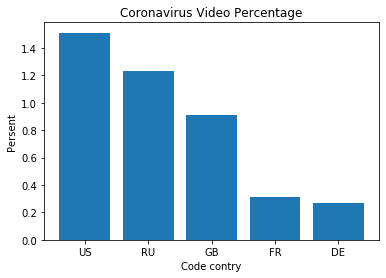

In [18]:
plt.bar(tc_coronavirus_agg.index, tc_coronavirus_agg['share_coronavirus'])
plt.xlabel('Code contry')
plt.ylabel('Persent')
plt.title('Coronavirus Video Percentage')

Данный график показывает популярность видео с упоминанием коронавируса.  
Представлена доля просмотров видео в % по отношению к просмотру всех трендовых видео.  
Данная столбчатая диаграмма удобно показывает соотношение по выбраным странам.

### 3 График.
График популярности трендовых видео в странах по жанрам

In [19]:
traces = []
for code in ['US', 'GB', 'DE', 'FR', 'RU']:
    traces.append(
        go.Histogram(
            x=tc[tc.index == code].category,
            histnorm='probability', 
            name = code, 
            visible = (code == 'US'))
    )
    
layout = go.Layout(
    title='Сategorization of videos by genre popularity',
    xaxis={'title':'category'},
    yaxis={'title':'share'},
    updatemenus=list([
        dict(
            x=-0.05,
            y=1,
            yanchor='top',
            buttons=list([
                dict(
                    args=['visible', [True] + [False]*4],
                    label='US',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False] + [True] + [False]*3],
                    label='GB',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False]*2 + [True] + [False]*2],
                    label='DE',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False]*3 + [True] + [False]],
                    label='FR',
                    method='restyle'
                ),
                dict(
                    args=['visible', [False]*4 + [True]],
                    label='RU',
                    method='restyle'
                )
            ]),
        )
    ]),
)


fig = {'data': traces, 'layout': layout}
iplot(fig, show_link=False)

График показывает популярность жарнов в разрезе каждой страны.  
По столбцу Y отображаются доля по количеству каждого жанра из всех трендовых видео.

### 4 График.
Отношение к новостям и политике. Посмотрим как пользователи относятся к категории News & Politics

In [20]:
tc.head()

,video_id,title,channelTitle,publishedAt,trending_date,tags,view_count,likes,dislikes,comment_count,categoryId,category
US,LOVxwVvUe_c,Nicki Minaj - Yikes (Official Audio),Nicki Minaj,2020-02-07 08:03:03,2020-02-08,nicki|minaj|nicki minaj 2019|nicki minaj|pink ...,2241192,188575,10612,21954,10,Music
US,hAjuvcQNzfw,"Mudding the $100,000 F350 Until it’s Ruined",WhistlinDiesel,2020-02-07 22:32:31,2020-02-08,whistlindiesel|ford|f350|f250|f150|raptor|dies...,590282,25228,2872,8153,22,People & Blogs
US,FXeDN7sQk30,Anuel AA - Keii [Official Video],Anuel AA,2020-02-07 05:00:31,2020-02-08,anuel aa|keii|real hasta la muerte|Anuel|Anuel...,9132471,467699,19609,18509,10,Music
US,c-yRN55iaQY,Lil Nas X - Rodeo (ft. Nas) [Official Video],LilNasXVEVO,2020-02-06 15:00:10,2020-02-08,LilNasX|Nas|Nas X|Rodeo Remix|Nas and Nas X|Hi...,7645550,544271,23576,45654,10,Music
US,4rNo-UuGDfA,Meek Mill - Believe (feat. Justin Timberlake) ...,Meek Mill,2020-02-07 05:06:48,2020-02-08,meek mill|meek|mill|hip hop|rap|atlantic|wins ...,1796732,111084,2737,8550,10,Music


In [21]:
# Рассчитаем долю просмотров категории News & Politics по отношению к просмотрам всех трендовых видео

In [22]:
tc_agg_df = tc[['view_count','category']].groupby([tc.index, 'category']).sum()
tc_agg_df.head()

view_count
   category                    
DE Autos & Vehicles    51708663
   Comedy               1834583
   Education             497833
   Entertainment       66841419
   Film & Animation     4477050

In [23]:
tc_agg_df = tc_agg_df.unstack('category').T
tc_agg_df

DE           FR           GB  \
           category                                                      
view_count Autos & Vehicles       51708663.0   52090500.0   45895732.0   
           Comedy                  1834583.0   14602321.0   27441918.0   
           Education                497833.0    1098752.0    4283350.0   
           Entertainment          66841419.0   35129793.0  179838372.0   
           Film & Animation        4477050.0    2569536.0    7630735.0   
           Gaming                 13972587.0    6273730.0   18003479.0   
           Hobbies and style        268556.0          NaN          NaN   
           Howto & Style           2737252.0    4233208.0   10589701.0   
           Music                 193549489.0  210779618.0  189150318.0   
           News & Politics         5331006.0    2450518.0    7316628.0   
           People & Blogs          5784776.0    3531936.0   20080551.0   
           Pets & Animals                NaN     104901.0          NaN   
           Science & Technology    1903412.0    2072142.0   38423110.0   
           Society                       NaN          NaN          NaN   
           Sports                142804813.0  147651318.0  150410925.0   
           Travel & Events               NaN     154751.0    1003557.0   

                                         RU           US  
           category                                       
view_count Autos & Vehicles       4995684.0   15682457.0  
           Comedy                 3280946.0   42559915.0  
           Education                    NaN   29048070.0  
           Entertainment         17441154.0  148833877.0  
           Film & Animation       5852056.0   33339424.0  
           Gaming                  729219.0   11180628.0  
           Hobbies and style            NaN          NaN  
           Howto & Style          1048190.0   12391556.0  
           Music                 10257620.0  182572581.0  
           News & Politics        2840254.0   13181065.0  
           People & Blogs         8841181.0   31346589.0  
           Pets & Animals         1048583.0          NaN  
           Science & Technology   2085006.0    3504388.0  
           Society                 742929.0          NaN  
           Sports                 3444189.0  152397804.0  
           Travel & Events         416253.0          NaN

In [26]:
# Рассчёт доли
tc_agg_df = tc_agg_df.apply(lambda x: 100*x/tc_agg_df.sum(), axis = 1)
tc_agg_df

DE         FR         GB         RU  \
           category                                                           
view_count Autos & Vehicles      10.516059  10.790524   6.555893   7.926730   
           Comedy                 0.373102   3.024864   3.919891   5.205928   
           Education              0.101245   0.227606   0.611847        NaN   
           Entertainment         13.593627   7.277121  25.688687  27.674152   
           Film & Animation       0.910504   0.532278   1.089999   9.285549   
           Gaming                 2.841623   1.299600   2.571674   1.157063   
           Hobbies and style      0.054617        NaN        NaN        NaN   
           Howto & Style          0.556679   0.876907   1.512667   1.663179   
           Music                 39.362413  43.662903  27.018835  16.275926   
           News & Politics        1.084174   0.507624   1.045130   4.506676   
           People & Blogs         1.176457   0.731639   2.868370  14.028440   
           Pets & Animals              NaN   0.021730        NaN   1.663803   
           Science & Technology   0.387099   0.429243   5.488480   3.308312   
           Society                     NaN        NaN        NaN   1.178817   
           Sports                29.042402  30.585904  21.485176   5.464949   
           Travel & Events             NaN   0.032057   0.143351   0.660475   

                                        US  
           category                         
view_count Autos & Vehicles       2.319758  
           Comedy                 6.295488  
           Education              4.296808  
           Entertainment         22.015597  
           Film & Animation       4.931588  
           Gaming                 1.653845  
           Hobbies and style           NaN  
           Howto & Style          1.832966  
           Music                 27.006246  
           News & Politics        1.949751  
           People & Blogs         4.636806  
           Pets & Animals              NaN  
           Science & Technology   0.518371  
           Society                     NaN  
           Sports                22.542775  
           Travel & Events             NaN

In [30]:
# Извлечение только категории News & Politics и изменение наименование индекса нулевого уровня
tc_agg_News_Politics_views = tc_agg_df[tc_agg_df.index.get_level_values(1) == 'News & Politics']
tc_agg_News_Politics_views.rename(index={'view_count':'Share_view_of_total_views'},inplace=True)
tc_agg_News_Politics_views

,,DE,FR,GB,RU,US
,category,,,,,
Share_view_of_total_views,News & Politics,1.084174,0.507624,1.04513,4.506676,1.949751


In [31]:
# Теперь рассчитаем долю одобрения видео и неодобрения видео. 
# Т.е. Количество лайков/Число просмотров и Количество дислайков/число просмотров соответственно

In [32]:
tc_agg_df = tc[['view_count','likes','dislikes','category']].groupby([tc.index, 'category']).sum()
tc_agg_df.head()

view_count    likes  dislikes
   category                                       
DE Autos & Vehicles    51708663   142821      4599
   Comedy               1834583   154098      2322
   Education             497833    26100      1220
   Entertainment       66841419  3374418    114554
   Film & Animation     4477050    45024      1931

In [33]:
# Расчёт долей
tc_agg_df['share_of_likes_from_views'] = tc_agg_df.apply(lambda row: row['likes']/row['view_count'], axis = 1)
tc_agg_df['share_of_dislikes_from_views'] = tc_agg_df.apply(lambda row: row['dislikes']/row['view_count'], axis = 1)

In [34]:
# Отбираем только категорию 'News & Politics' и фильтруем только нужные столбцы
tc_agg_News_Politics_likes_dislikes = tc_agg_df.loc[tc_agg_df.index.get_level_values(1) == 'News & Politics',
                                                    ['share_of_likes_from_views','share_of_dislikes_from_views']]*100
tc_agg_News_Politics_likes_dislikes

,,share_of_likes_from_views,share_of_dislikes_from_views
,category,,
DE,News & Politics,1.204988,0.145620
FR,News & Politics,1.692703,0.038686
GB,News & Politics,1.572692,0.119372
RU,News & Politics,3.996298,0.246457
US,News & Politics,1.447129,0.302540


In [35]:
# Транспонируем DataFrame
tc_agg_News_Politics_likes_dislikes = tc_agg_News_Politics_likes_dislikes.unstack('category').T
tc_agg_News_Politics_likes_dislikes

,,DE,FR,GB,RU,US
,category,,,,,
share_of_likes_from_views,News & Politics,1.204988,1.692703,1.572692,3.996298,1.447129
share_of_dislikes_from_views,News & Politics,0.145620,0.038686,0.119372,0.246457,0.302540


In [36]:
# Объединяем DataFrame с долей просмотра категории 'News & Politics' и DataFrame с долями лайков и дислайков
tc_agg_News_Politics = pd.concat([tc_agg_News_Politics_views, tc_agg_News_Politics_likes_dislikes], sort = False)
tc_agg_News_Politics

,,DE,FR,GB,RU,US
,category,,,,,
Share_view_of_total_views,News & Politics,1.084174,0.507624,1.045130,4.506676,1.949751
share_of_likes_from_views,News & Politics,1.204988,1.692703,1.572692,3.996298,1.447129
share_of_dislikes_from_views,News & Politics,0.145620,0.038686,0.119372,0.246457,0.302540


In [37]:
# Удаляем столбец с индексом 'category' для того, чобы не захламлять график
tc_agg_News_Politics.reset_index('category', drop=True, inplace=True)
# Добавляем наименование индекса с указанием нужных нам показателей
tc_agg_News_Politics = tc_agg_News_Politics.rename_axis(['indicator'])
tc_agg_News_Politics

,DE,FR,GB,RU,US
indicator,,,,,
Share_view_of_total_views,1.084174,0.507624,1.045130,4.506676,1.949751
share_of_likes_from_views,1.204988,1.692703,1.572692,3.996298,1.447129
share_of_dislikes_from_views,0.145620,0.038686,0.119372,0.246457,0.302540


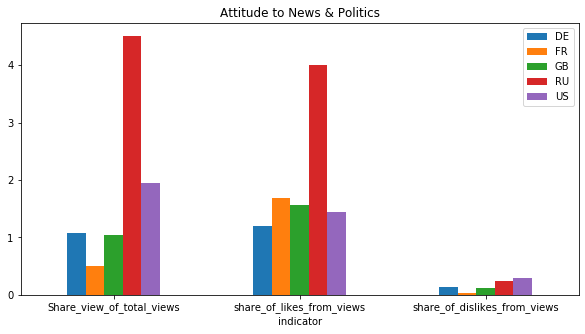

In [38]:
tc_agg_News_Politics.plot(kind='bar', figsize=(10,5), rot=0, title='Attitude to News & Politics')

На графике отражается отношение пользователей Youtube к категории видео 'News & Politics' среди трендовых видео.  
1. Share_view_of_total_views - это доля просмотров видео группы 'News & Politics' от просмотров всех остальных видео.
   Видно, что в целом пользователи Youtube не очень политизированы, при этом пользователи из России больше всего              интересуются новостями и политиков, меньше всего пользователи из Франции.
2. share_of_likes_from_views - это доля лайков от общего количества просмотров. Одобряют видео больше всего пользователи из    Росии, меньше всего из Германии - они просто смотрят
3. share_of_dislikes_from_views - это доля дислайков от общего количества просмотров. Чаще всего пользователи ставят          дислайки в США, меньше всего во Франции.

### 5 График.
Рассмотрим корреляцию между количеством просмотров, лайков и дислайков

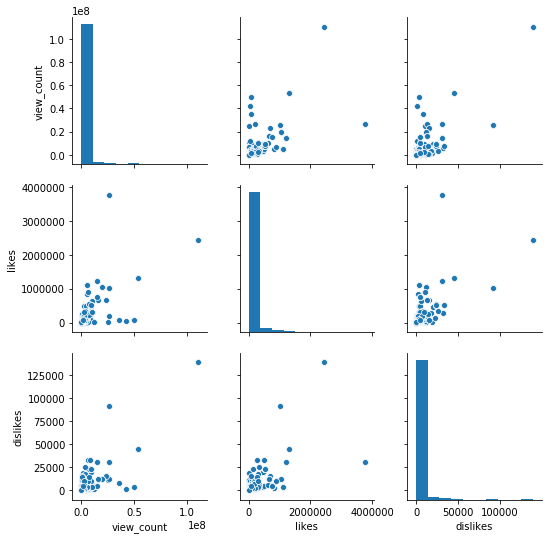

In [39]:
# Рассмотрим связь между просмотрами, лайками и дислайками по всем странам и категориям
sns_plot = sns.pairplot(
    tc[['view_count','likes','dislikes']])
sns_plot

In [40]:
# Рассчитаем линейный коэффициент корелляции (коэффициент Пирсона)
view_count = list(tc['view_count'])
likes = list(tc['likes'])
dislikes = list(tc['dislikes'])

corr1, p_value1 = pearsonr(view_count, likes)
corr2, p_value2 = pearsonr(view_count, dislikes)
corr3, p_value3 = pearsonr(likes, dislikes)

print('Коэффициент корреляции Пирсона между просмотрами и лайками:', corr1)
print('Коэффициент корреляции Пирсона между просмотрами и дислайками:', corr2)
print('Коэффициент корреляции Пирсона между лайками и дислайками:', corr3)

Коэффициент корреляции Пирсона между просмотрами и лайками: 0.7175649991979937
Коэффициент корреляции Пирсона между просмотрами и дислайками: 0.8582911948667318
Коэффициент корреляции Пирсона между лайками и дислайками: 0.7166201526775939


In [41]:
# Уберем выбросы (строки с просмотрами от 30 млн.)
tc_corr = tc[tc['view_count']<30000000]

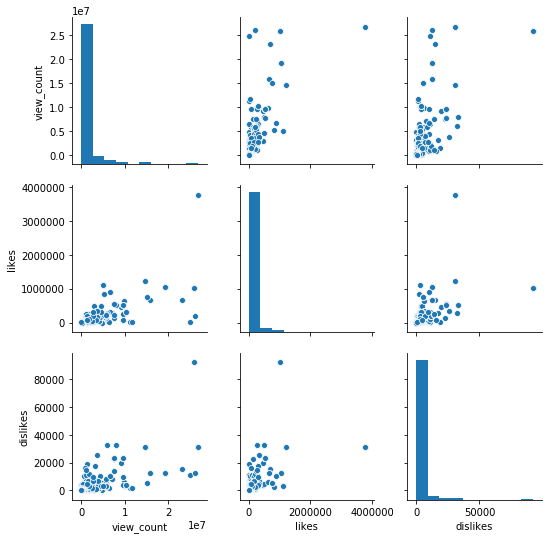

In [42]:
sns_plot = sns.pairplot(
    tc_corr[['view_count','likes','dislikes']])
sns_plot

        Судя по графику корреляция между лайками и просмотрами существует, но не столь явная. При увеличении количества просмотров лайки не так сильно увеличиваются. Скорее всего люди по нескольку раз просматривают трендовые видео, особенно это касается музыки. И также просматривают то, что модно, то что подсовывает им сам YouTube при этом относясь к этим видео достаточно равнодушно.  
        Похожая ситуация и с дислайками, но всё же корреляция больше. Думаю, это опять же связано с тем, что люди смотрят то, что им подсовывает YouTube, а не то что они бы искали.  